# Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import random

# 1. Integridad y Estructura del Dataset

In [2]:
TRAIN_DIR = 'train/' 
TEST_DIR = 'test/images/'

TRAIN_IMAGES_DIR = os.path.join(TRAIN_DIR, 'images')
TRAIN_MASKS_DIR = os.path.join(TRAIN_DIR, 'masks')
TEST_IMAGES_DIR = os.path.join(TEST_DIR)

# Filtrar archivos PNG
img_files = sorted([f for f in os.listdir(TRAIN_IMAGES_DIR) if f.lower().endswith('.png')])
mask_files = sorted([f for f in os.listdir(TRAIN_MASKS_DIR) if f.lower().endswith('.png')])
test_files = sorted([f for f in os.listdir(TEST_IMAGES_DIR) if f.lower().endswith('.png')])

# =========================================================
# FUNCIÓN ROBUSTA DE CARGA DE MÁSCARAS (Canal Alfa/Grayscale)
# =========================================================
def load_mask_robust(mask_path):
    """
    Intenta cargar la máscara. Prioriza el Canal Alfa, luego el Grayscale.
    Devuelve la máscara como un array binario (0 o 1).
    """
    # 1. Intento con PIL (más robusto para PNGs y Canal Alfa)
    try:
        img = Image.open(mask_path)
        
        if img.mode == 'RGBA':
            # Extraer el Canal Alfa (4to canal)
            raw_mask = np.array(img.split()[-1], dtype=np.uint8)
        elif img.mode == 'L':
            # Grayscale de un canal
            raw_mask = np.array(img, dtype=np.uint8)
        elif img.mode == 'RGB':
            # Si es RGB, a veces la info está en un solo canal (ej. R)
            raw_mask = np.array(img.split()[0], dtype=np.uint8)
        else:
            return None # Modo no soportado
            
        # Binarizar: Píxeles de segmentación > 0 se vuelven 1
        return (raw_mask > 0).astype(np.uint8) 

    except Exception:
        # Fallo en la lectura con PIL, puede que el archivo esté corrupto
        return None 



In [3]:
# =========================================================
# 1. VERIFICACIÓN DE INTEGRIDAD Y ESTRUCTURA
# =========================================================
print("--- 1. VERIFICACIÓN DE INTEGRIDAD Y ESTRUCTURA ---")
print(f"📸 Total de imágenes de entrenamiento: {len(img_files)}")
print(f"🎭 Total de máscaras de entrenamiento: {len(mask_files)}")
print(f"🧪 Total de imágenes de prueba (Test): {len(test_files)}")

# 1.1 Coincidencia de Nombres
img_names = set([os.path.splitext(f)[0] for f in img_files])
mask_names = set([os.path.splitext(f)[0] for f in mask_files])

if img_names == mask_names:
    print("✅ Coincidencia de nombres: Todos los pares imagen/máscara están completos.")
else:
    print(f"⚠️ ¡ERROR DE PARES! Faltan {len(img_names - mask_names)} máscaras o {len(mask_names - img_files)} imágenes.")

# 1.2 Chequeo de Tamaño y Formato (Muestra)
if not img_files:
    print("❌ No hay imágenes para verificar.")
else:
    sample_img_path = os.path.join(TRAIN_IMAGES_DIR, img_files[0])
    sample_mask_path = os.path.join(TRAIN_MASKS_DIR, mask_files[0])
    
    # Imagen RGB
    sample_image = cv2.imread(sample_img_path)
    # Máscara (usando la función robusta)
    sample_mask_binary = load_mask_robust(sample_mask_path)

    if sample_image is not None and sample_mask_binary is not None:
        print(f"\n  Tamaño de la imagen de muestra: {sample_image.shape[:2]}")
        print(f"  Canales de la imagen: {sample_image.shape[2]} (RGB)")
        print(f"  Tamaño de la máscara decodificada: {sample_mask_binary.shape}")
        
        # Validar el formato 800x800
        if sample_image.shape[:2] == (800, 800) and sample_mask_binary.shape == (800, 800):
            print("✅ Formato uniforme: 800x800 confirmado.")
        else:
            print("⚠️ ADVERTENCIA: Tamaños no son 800x800. Se requiere redimensionamiento en el preprocesamiento.")

# 1.3 Verificación de Máscaras Vacías
empty_masks, full_masks = 0, 0
total_pixels = 800 * 800 # Asumiendo 800x800

print("\n  Chequeando máscaras vacías o llenas...")
for f in tqdm(mask_files, desc="Contando máscaras sin segmentación"):
    mask_bin = load_mask_robust(os.path.join(TRAIN_MASKS_DIR, f))
    
    if mask_bin is not None:
        # np.sum(mask_bin) cuenta los píxeles con valor 1
        sum_pixels = np.sum(mask_bin)
        if sum_pixels == 0:
            empty_masks += 1
        elif sum_pixels == total_pixels:
            full_masks += 1

print(f"  Máscaras totalmente vacías (sin persona): {empty_masks} ({empty_masks / len(mask_files) * 100:.2f}%)")
print(f"  Máscaras totalmente llenas (cuerpo completo): {full_masks} ({full_masks / len(mask_files) * 100:.2f}%)")
print("✅ Conteo de integridad finalizado.")

--- 1. VERIFICACIÓN DE INTEGRIDAD Y ESTRUCTURA ---
📸 Total de imágenes de entrenamiento: 2133
🎭 Total de máscaras de entrenamiento: 2133
🧪 Total de imágenes de prueba (Test): 534
✅ Coincidencia de nombres: Todos los pares imagen/máscara están completos.

  Tamaño de la imagen de muestra: (800, 800)
  Canales de la imagen: 3 (RGB)
  Tamaño de la máscara decodificada: (800, 800)
✅ Formato uniforme: 800x800 confirmado.

  Chequeando máscaras vacías o llenas...


Contando máscaras sin segmentación: 100%|██████████| 2133/2133 [00:24<00:00, 87.71it/s]

  Máscaras totalmente vacías (sin persona): 0 (0.00%)
  Máscaras totalmente llenas (cuerpo completo): 2 (0.09%)
✅ Conteo de integridad finalizado.


# 2. Cálculo de Estadísticas de Color

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def calculate_stats_and_pixels(image_dir, file_list):
    """
    Calcula la media, la desviación estándar y recolecta una muestra de píxeles
    para generar histogramas. Usa la doble pasada para eficiencia.
    """
    
    # 1. Variables para Media/STD
    mean_sum = np.zeros(3, dtype=np.float64) 
    pixel_count = 0
    
    # 2. Variables para Histograma (Recolección de una muestra de píxeles)
    all_pixels = []
    
    print("\n--- 2. CÁLCULO DE MEDIA, STD Y RECOLECCIÓN DE PÍXELES ---")

    # --- Primera Pasada: Media y Recolección ---
    for filename in tqdm(file_list, desc="Paso 1/2: Media y Recolección"):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        
        if img is None:
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img_array = img.astype(np.float64) / 255.0 # Normalizar a [0, 1]

        H, W, C = img_array.shape
        pixel_count += H * W
        mean_sum += np.sum(img_array, axis=(0, 1))

        # Recolección: Tomar una muestra aleatoria de píxeles para el histograma 
        # (Esto evita cargar todos los datos, lo cual puede ser enorme)
        sample_size = min(1000, H * W) # Muestrear hasta 1000 píxeles por imagen
        indices = np.random.choice(H * W, size=sample_size, replace=False)
        flat_array = img_array.reshape(-1, 3)
        all_pixels.append(flat_array[indices])

    mean_channels = mean_sum / pixel_count
    
    # --- Segunda Pasada: Desviación Estándar ---
    std_sum = np.zeros(3, dtype=np.float64)
    for filename in tqdm(file_list, desc="Paso 2/2: Desviación Estándar"):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        
        if img is None:
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = img.astype(np.float64) / 255.0 

        std_sum += np.sum((img_array - mean_channels)**2, axis=(0, 1))

    variance_channels = std_sum / pixel_count
    std_channels = np.sqrt(variance_channels)
    
    # Concatenar todos los píxeles muestreados
    all_pixels_array = np.concatenate(all_pixels, axis=0)
    
    return mean_channels, std_channels, all_pixels_array

# 1. Ejecutar el cálculo
train_mean, train_std, pixel_samples = calculate_stats_and_pixels(TRAIN_IMAGES_DIR, img_files) 


--- 2. CÁLCULO DE MEDIA, STD Y RECOLECCIÓN DE PÍXELES ---


Paso 2/2: Desviación Estándar: 100%|██████████| 2133/2133 [01:10<00:00, 30.33it/s]


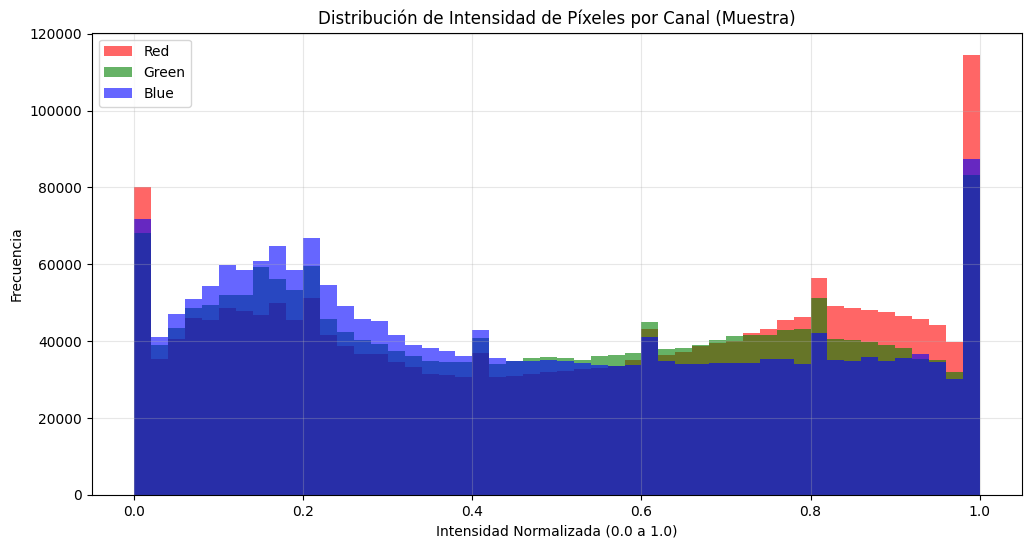


--- Resultados de Estadísticas de Color ---
📊 Media por canal (R, G, B): [0.51497809 0.483988   0.45972021]
📊 Desviación Estándar por canal (R, G, B): [0.31370317 0.30283147 0.30339838]

Justificación de Preprocesamiento:
El histograma visualiza la distribución de color, mostrando si hay dominancia de color o picos en los extremos (negro/blanco).
Los valores $\mu$ y $\sigma$ calculados son esenciales para la Normalización Z-score: Imagen_norm = (Imagen - $\mu$) / $\sigma$. Esta técnica centrará los datos de entrada alrededor de cero, lo que es crucial para acelerar y mejorar la convergencia de la U-Net.


In [5]:
# 2. Generar el Histograma de Intensidad
colors = ['Red', 'Green', 'Blue']

plt.figure(figsize=(12, 6))
plt.title('Distribución de Intensidad de Píxeles por Canal (Muestra)')
plt.xlabel('Intensidad Normalizada (0.0 a 1.0)')
plt.ylabel('Frecuencia')

for i, color in enumerate(colors):
    # Generar el histograma a partir de la muestra de píxeles
    plt.hist(pixel_samples[:, i], bins=50, alpha=0.6, label=color, color=color.lower())
    
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 3. Imprimir los resultados y la justificación
print("\n--- Resultados de Estadísticas de Color ---")
print(f"📊 Media por canal (R, G, B): {train_mean}")
print(f"📊 Desviación Estándar por canal (R, G, B): {train_std}")

print("\nJustificación de Preprocesamiento:")
print("El histograma visualiza la distribución de color, mostrando si hay dominancia de color o picos en los extremos (negro/blanco).")
print(f"Los valores $\mu$ y $\sigma$ calculados son esenciales para la Normalización Z-score: Imagen_norm = (Imagen - $\mu$) / $\sigma$. Esta técnica centrará los datos de entrada alrededor de cero, lo que es crucial para acelerar y mejorar la convergencia de la U-Net.")

# 3. Análisis del Desequilibrio de Píxeles y Justificación de la Función de Pérdida


--- 3. ANÁLISIS DE DESEQUILIBRIO DE PÍXELES (Área Corporal) ---


Calculando proporción de píxeles positivos: 100%|██████████| 2133/2133 [00:04<00:00, 438.55it/s]


--- Resultados de Desequilibrio ---
📈 Promedio de píxeles positivos (Clase Persona): 39.90%
📉 Desviación estándar del área: 21.16%
🔍 Rango del área corporal: 1.04% - 100.00%


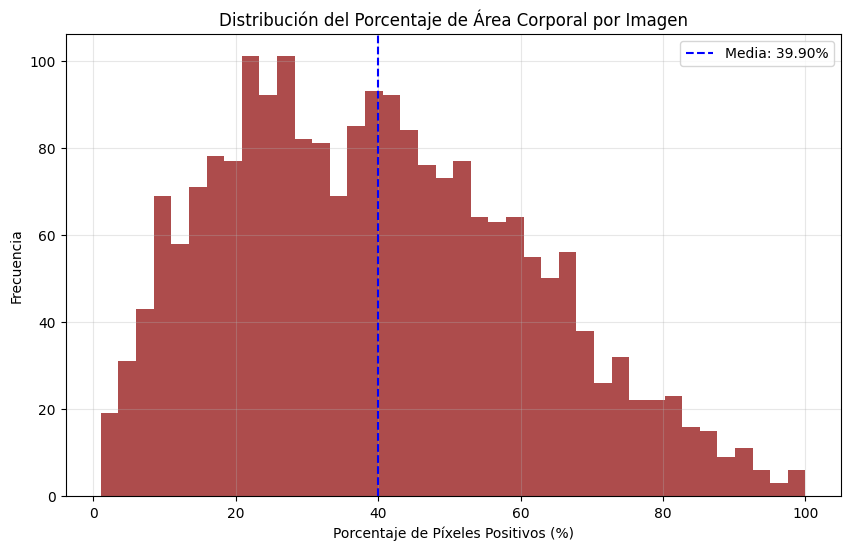


**Justificación de la Función de Pérdida (Loss Function):**
El análisis de desequilibrio muestra que la clase de interés ('Persona') es una clase **minoritaria**, ocupando en promedio solo el **39.90%** del área total.
Este desequilibrio severo conlleva un riesgo: la función de pérdida tradicional (Binary Cross-Entropy) será dominada por la clase mayoritaria ('Fondo').
Por lo tanto, se justifica el uso de la **Dice Loss** (o una combinación BCE + Dice), ya que se enfoca en la métrica de superposición (Dice Coefficient). Esto garantiza que el modelo priorice la **correcta segmentación** de los pocos píxeles de 'Persona', en lugar de simplemente ser bueno para identificar el 'Fondo'.


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Asumiendo que estas variables y funciones están definidas:
# TRAIN_MASKS_DIR, mask_files, load_mask_robust
# total_pixels = 800 * 800 (Si el tamaño es fijo)

# Determinar el número total de píxeles por máscara (Asumiendo 800x800)
try:
    # Usamos un valor fijo si ya confirmamos el tamaño en el Paso 1
    total_pixels = 800 * 800 
except NameError:
    # Fallback por si la variable no está definida
    print("Determinando el tamaño de la máscara...")
    sample_mask = load_mask_robust(os.path.join(TRAIN_MASKS_DIR, mask_files[0]))
    if sample_mask is not None:
        total_pixels = sample_mask.shape[0] * sample_mask.shape[1]
    else:
        print("Error: No se pudo cargar la máscara de muestra.")
        total_pixels = 1 # Valor dummy para evitar división por cero


mask_areas = []
valid_masks_count = 0

print("\n--- 3. ANÁLISIS DE DESEQUILIBRIO DE PÍXELES (Área Corporal) ---")

for f in tqdm(mask_files, desc="Calculando proporción de píxeles positivos"):
    mask_bin = load_mask_robust(os.path.join(TRAIN_MASKS_DIR, f))
    
    if mask_bin is not None:
        valid_masks_count += 1
        # La suma en la máscara binarizada (0/1) da el número de píxeles de "Persona"
        ratio = np.sum(mask_bin) / total_pixels
        mask_areas.append(ratio)

mask_areas = np.array(mask_areas)

# 1. Resultados Estadísticos
if valid_masks_count > 0:
    mean_ratio = mask_areas.mean() * 100
    std_ratio = mask_areas.std() * 100
    min_ratio = mask_areas.min() * 100
    max_ratio = mask_areas.max() * 100
    
    print("\n--- Resultados de Desequilibrio ---")
    print(f"📈 Promedio de píxeles positivos (Clase Persona): {mean_ratio:.2f}%")
    print(f"📉 Desviación estándar del área: {std_ratio:.2f}%")
    print(f"🔍 Rango del área corporal: {min_ratio:.2f}% - {max_ratio:.2f}%")

    # 2. Generar el Histograma de Distribución de Área
    plt.figure(figsize=(10, 6))
    plt.hist(mask_areas * 100, bins=40, color='darkred', alpha=0.7)
    plt.title('Distribución del Porcentaje de Área Corporal por Imagen')
    plt.xlabel('Porcentaje de Píxeles Positivos (%)')
    plt.ylabel('Frecuencia')
    plt.axvline(mean_ratio, color='blue', linestyle='dashed', linewidth=1.5, label=f'Media: {mean_ratio:.2f}%')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# 3. Justificación Clave para el EDA
    print("\n**Justificación de la Función de Pérdida (Loss Function):**")
    print(f"El análisis de desequilibrio muestra que la clase de interés ('Persona') es una clase **minoritaria**, ocupando en promedio solo el **{mean_ratio:.2f}%** del área total.")
    print("Este desequilibrio severo conlleva un riesgo: la función de pérdida tradicional (Binary Cross-Entropy) será dominada por la clase mayoritaria ('Fondo').")
    print("Por lo tanto, se justifica el uso de la **Dice Loss** (o una combinación BCE + Dice), ya que se enfoca en la métrica de superposición (Dice Coefficient). Esto garantiza que el modelo priorice la **correcta segmentación** de los pocos píxeles de 'Persona', en lugar de simplemente ser bueno para identificar el 'Fondo'.")

else:
    print("No se encontraron máscaras válidas para el análisis de desequilibrio.")

# 4. Visualización Exploratoria


--- 4. VISUALIZACIÓN EXPLORATORIA ---


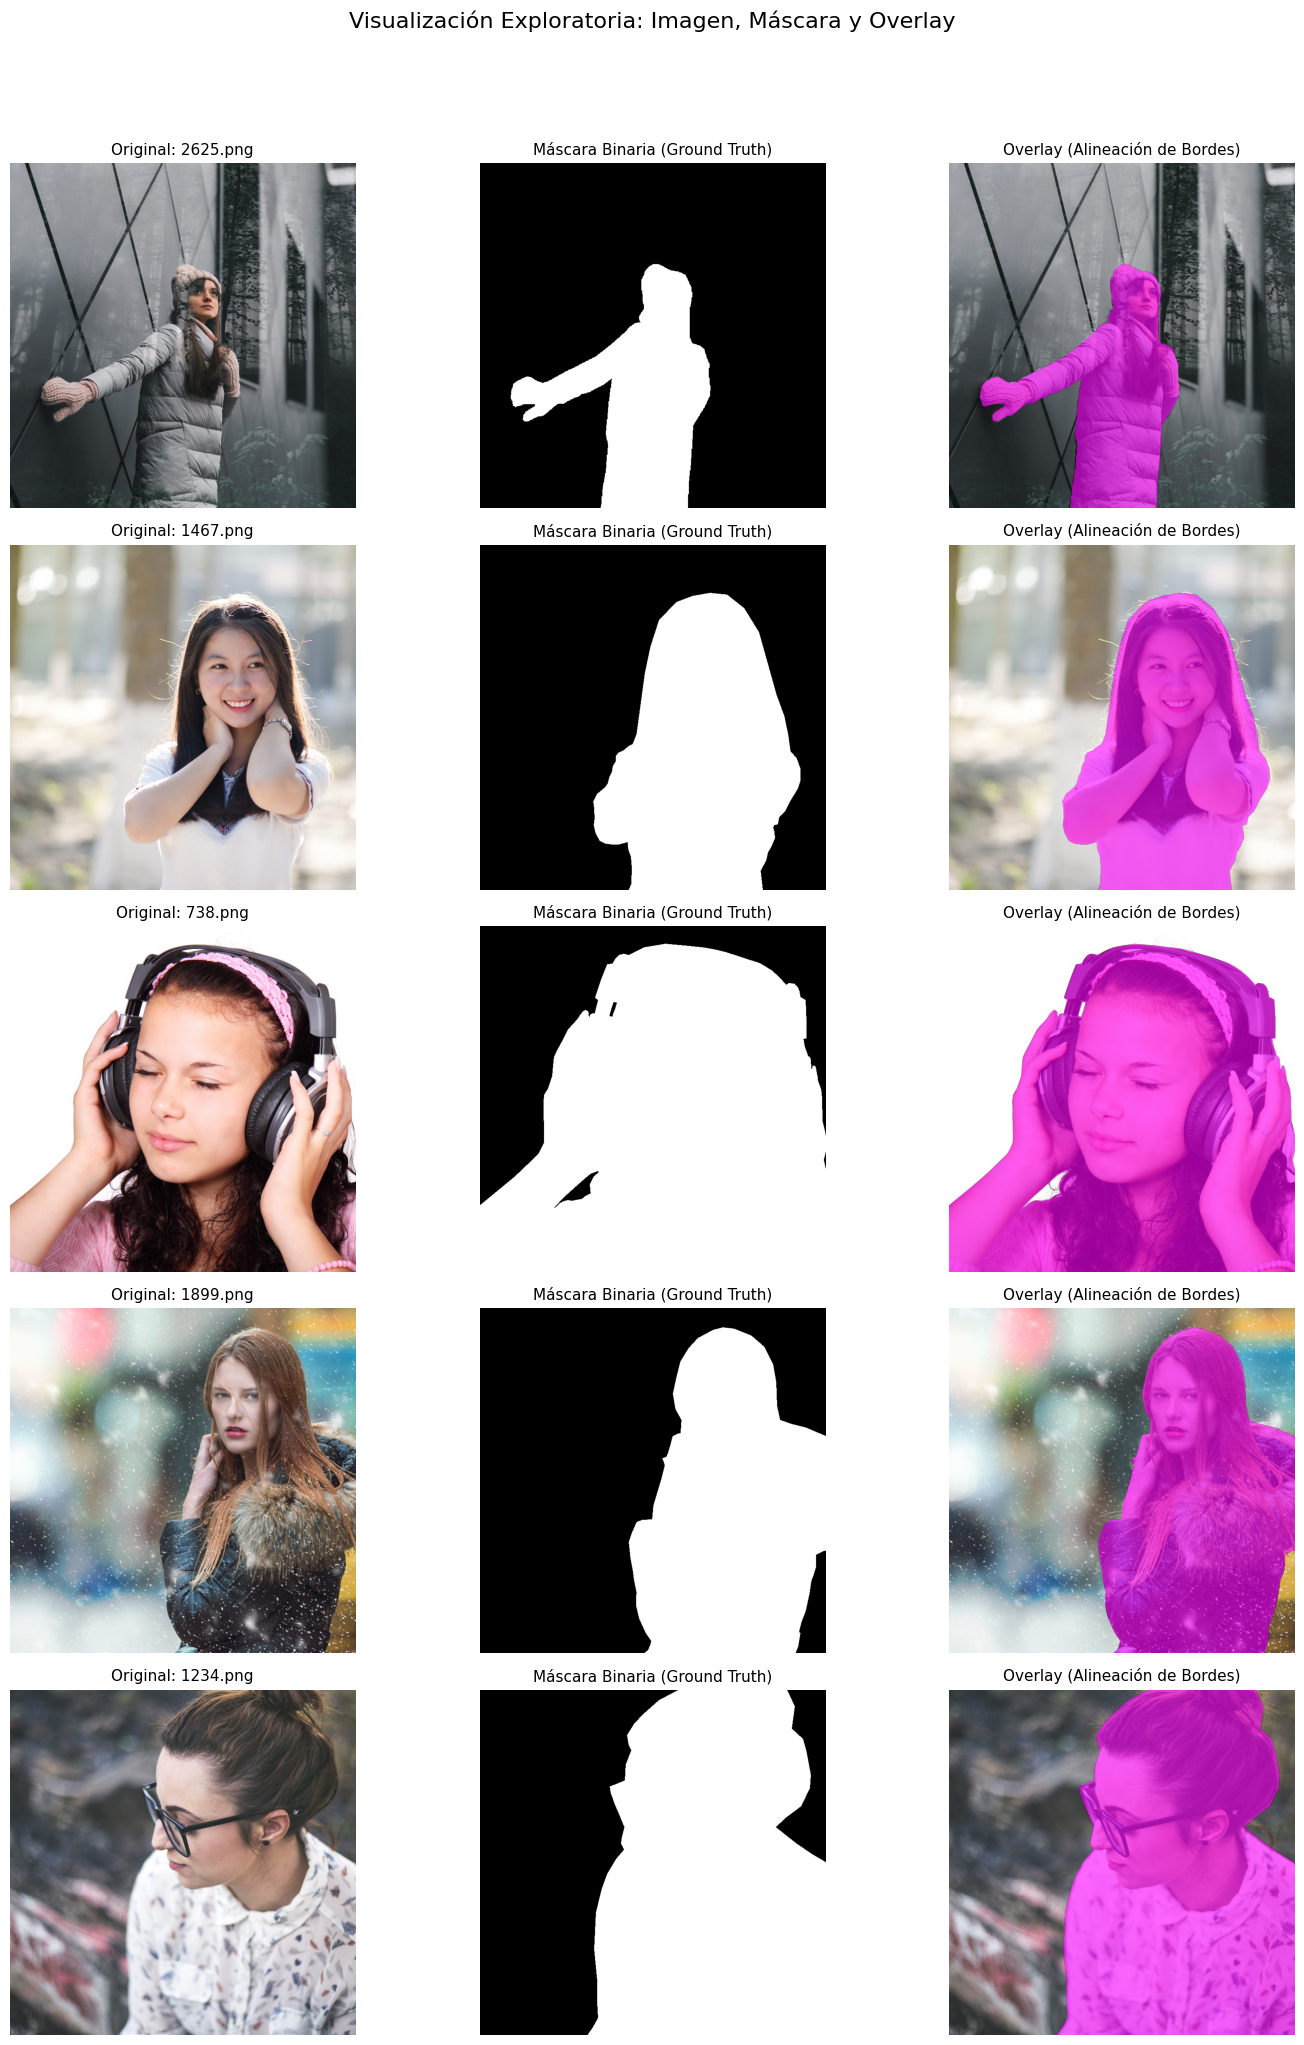


Justificación de la Arquitectura U-Net (Skip Connections):
La inspección visual (especialmente en el Overlay) revela la necesidad de alta precisión en los bordes de la segmentación. Pequeños errores de alineación alrededor del cabello, manos o ropa se penalizarían fuertemente.
Esto justifica el uso de las Skip Connections del U-Net, ya que estas transfieren la información espacial de alta resolución (detalles finos, bordes) directamente desde el encoder al decoder. Sin esta transferencia, el decoder solo tendría acceso a la información de baja resolución y el resultado sería una segmentación borrosa o imprecisa.


In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Asumiendo que estas variables y funciones están definidas:
# TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, img_files, load_mask_robust

def visualize_samples_overlay(img_dir, mask_dir, file_list, num_samples=5):
    """
    Muestra la Imagen Original, la Máscara Binaria y la Superposición (Overlay) 
    para validar la alineación y la calidad de los bordes.
    """
    
    # Seleccionar archivos de muestra
    sample_files = random.sample(file_list, num_samples)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))
    fig.suptitle('Visualización Exploratoria: Imagen, Máscara y Overlay', fontsize=16, y=1.02)
    
    # Asegurar que 'axes' sea un array 2D incluso para num_samples=1
    if num_samples == 1: 
        axes = axes.reshape(1, -1) 

    print("\n--- 4. VISUALIZACIÓN EXPLORATORIA ---")
    
    for i, filename in enumerate(sample_files):
        # 1. Cargar Imagen (BGR -> RGB)
        img_bgr = cv2.imread(os.path.join(img_dir, filename))
        if img_bgr is None:
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # 2. Cargar Máscara (Usando la función robusta del Paso 1)
        mask_bin = load_mask_robust(os.path.join(mask_dir, filename))
        
        if mask_bin is None:
            continue
        
        # --- Columna 1: IMAGEN ORIGINAL ---
        axes[i, 0].imshow(img_rgb)
        axes[i, 0].set_title(f'Original: {filename}', fontsize=11)
        axes[i, 0].axis('off')

        # --- Columna 2: MÁSCARA GROUND TRUTH ---
        # Multiplicamos por 255 para que el 1 binario se vea blanco
        axes[i, 1].imshow(mask_bin * 255, cmap='gray')
        axes[i, 1].set_title('Máscara Binaria (Ground Truth)', fontsize=11)
        axes[i, 1].axis('off')
        
        # --- Columna 3: OVERLAY (Superposición) ---
        axes[i, 2].imshow(img_rgb)
        # Creamos una capa para la máscara: se muestra solo donde la máscara es 1
        masked_overlay = np.ma.masked_where(mask_bin == 0, mask_bin)
        axes[i, 2].imshow(masked_overlay, cmap='spring', alpha=0.6) # Usamos un color brillante
        axes[i, 2].set_title('Overlay (Alineación de Bordes)', fontsize=11)
        axes[i, 2].axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Ejecutar la visualización con 5 ejemplos
visualize_samples_overlay(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, img_files, num_samples=5)


print("\nJustificación de la Arquitectura U-Net (Skip Connections):")
print("La inspección visual (especialmente en el Overlay) revela la necesidad de alta precisión en los bordes de la segmentación. Pequeños errores de alineación alrededor del cabello, manos o ropa se penalizarían fuertemente.")
print("Esto justifica el uso de las Skip Connections del U-Net, ya que estas transfieren la información espacial de alta resolución (detalles finos, bordes) directamente desde el encoder al decoder. Sin esta transferencia, el decoder solo tendría acceso a la información de baja resolución y el resultado sería una segmentación borrosa o imprecisa.")

# 5. Análisis Cuantitativo de Color (Brillo, Contraste, Saturación)


--- 5. CÁLCULO DE BRILLO, CONTRASTE Y SATURACIÓN (HSV) ---


Analizando métricas de color: 100%|██████████| 2133/2133 [00:26<00:00, 81.98it/s]


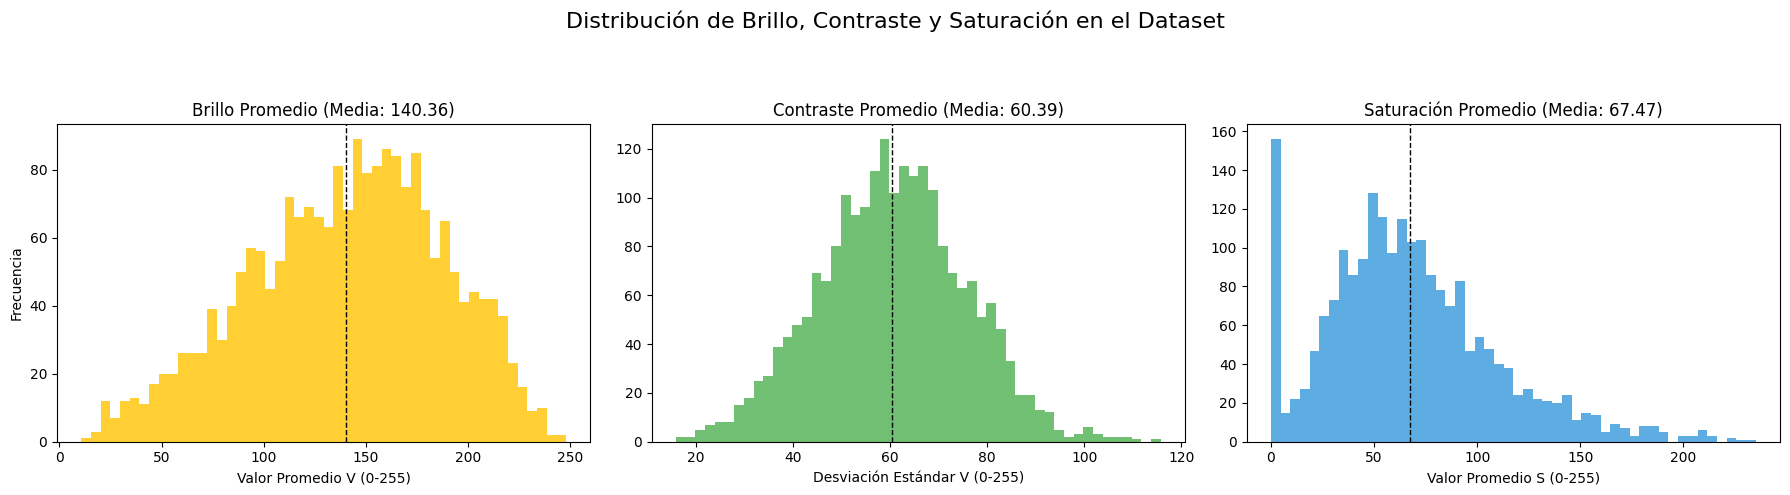

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Asumiendo que TRAIN_IMAGES_DIR y img_files están definidos

def calculate_color_metrics(image_dir, file_list):
    """
    Calcula el brillo (media V), el contraste (desviación estándar V) 
    y la saturación (media S) para todas las imágenes.
    """
    
    brightness_list = []
    contrast_list = []
    saturation_list = []
    
    print("\n--- 5. CÁLCULO DE BRILLO, CONTRASTE Y SATURACIÓN (HSV) ---")

    for filename in tqdm(file_list, desc="Analizando métricas de color"):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        
        if img is None:
            continue
            
        # 1. Conversión al Espacio de Color HSV
        # HSV separa la intensidad (V) y el color (H, S)
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
        
        # Canales (H: Hue, S: Saturación, V: Valor/Brillo)
        H, S, V = cv2.split(img_hsv) 
        
        # 2. Brillo (Brightness): Media del canal V
        brightness_list.append(V.mean())
        
        # 3. Contraste (Contrast): Desviación Estándar del canal V
        contrast_list.append(V.std())
        
        # 4. Saturación (Saturation): Media del canal S
        saturation_list.append(S.mean())

    return np.array(brightness_list), np.array(contrast_list), np.array(saturation_list)

# 1. Ejecutar el cálculo
brightness_array, contrast_array, saturation_array = calculate_color_metrics(TRAIN_IMAGES_DIR, img_files)

# 2. Generar los Histogramas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribución de Brillo, Contraste y Saturación en el Dataset', fontsize=16)

# Brillo
axes[0].hist(brightness_array, bins=50, color='#FFC300', alpha=0.8)
axes[0].set_title(f'Brillo Promedio (Media: {brightness_array.mean():.2f})')
axes[0].set_xlabel('Valor Promedio V (0-255)')
axes[0].set_ylabel('Frecuencia')
axes[0].axvline(brightness_array.mean(), color='black', linestyle='dashed', linewidth=1)

# Contraste
axes[1].hist(contrast_array, bins=50, color='#4CAF50', alpha=0.8)
axes[1].set_title(f'Contraste Promedio (Media: {contrast_array.mean():.2f})')
axes[1].set_xlabel('Desviación Estándar V (0-255)')
axes[1].axvline(contrast_array.mean(), color='black', linestyle='dashed', linewidth=1)

# Saturación
axes[2].hist(saturation_array, bins=50, color='#3498DB', alpha=0.8)
axes[2].set_title(f'Saturación Promedio (Media: {saturation_array.mean():.2f})')
axes[2].set_xlabel('Valor Promedio S (0-255)')
axes[2].axvline(saturation_array.mean(), color='black', linestyle='dashed', linewidth=1)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

# 6. Calidad de Máscaras

In [19]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import random

# Asumiendo que TRAIN_MASKS_DIR, mask_files y load_mask_robust están definidos

def analyze_mask_quality_cv2_only(mask_dir, file_list):
    """
    Identifica máscaras con ruido (agujeros o componentes desconectados) 
    utilizando solo cv2 y numpy.
    """
    
    noisy_masks = []
    
    # Kernel para operaciones morfológicas (ej. un círculo para suavizar)
    kernel = np.ones((5, 5), np.uint8) 
    
    print("\n--- 6.1 ANÁLISIS DE CALIDAD DE MÁSCARAS (Ruido/Agujeros) ---")
    
    for filename in tqdm(file_list, desc="Analizando ruido y componentes"):
        # La máscara debe ser binaria (0 o 1) para las operaciones
        mask_bin = load_mask_robust(os.path.join(mask_dir, filename))
        
        if mask_bin is None: continue
        
        # Aseguramos que sea UINT8, que es el formato que CV2 espera para la mayoría de sus funciones
        mask_uint8 = mask_bin.astype(np.uint8) 
        
        # 1. Detección de Agujeros (Holes)
        # Dilatación seguida de Erosión (Close) rellena pequeños agujeros internos
        # Si la suma de píxeles cambia, significa que se rellenó un agujero.
        mask_closed = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)
        holes_detected = np.sum(mask_closed) != np.sum(mask_uint8)
        
        # 2. Detección de Componentes Desconectados (Piezas separadas)
        # cv2.connectedComponentsWithStats: El primer valor (ret) es el número de componentes.
        # El componente 0 es siempre el fondo. Por lo tanto, (ret - 1) es el número de objetos.
        ret, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)
        
        # num_objects es el número de componentes conectados de la PERSONA (no el fondo)
        num_objects = ret - 1 
        
        if holes_detected or num_objects > 1:
            noisy_masks.append({
                'filename': filename,
                'holes': holes_detected,
                'components': num_objects
            })

    # --- Resultados y Justificación ---
    total_files = len(file_list)
    total_noisy = len(noisy_masks)
    
    print(f"\nTotal de máscaras potencialmente ruidosas/con componentes separados: {total_noisy}")
    
    # 3. Visualización de Casos Dudosos
    if noisy_masks:
        sample_error = random.choice(noisy_masks)
        print(f"\n⚠️ CASO DUDOSO DE MUESTRA: {sample_error['filename']}")
        print(f"  - Agujeros detectados: **{sample_error['holes']}**")
        print(f"  - Componentes separados: **{sample_error['components']}** (Se espera 1)")

    # 4. Justificación de Post-Procesamiento
    if total_files > 0 and total_noisy / total_files > 0.02: 
        print("\n**Decisión de Post-Procesamiento:**")
        print("Dado que la detección de ruido es significativa (> 2%), se recomienda aplicar operaciones morfológicas (como el cierre o la selección del componente más grande) a la **salida del modelo** para rellenar agujeros pequeños y asegurar un solo objeto por segmentación.")
    else:
        print("\n**Decisión de Post-Procesamiento:**")
        print("El ruido de la etiqueta es marginal. El post-procesamiento morfológico **no es obligatorio**.")

    return noisy_masks

# Llamar a la función corregida
analyze_mask_quality_cv2_only(TRAIN_MASKS_DIR, mask_files)


--- 6.1 ANÁLISIS DE CALIDAD DE MÁSCARAS (Ruido/Agujeros) ---


Analizando ruido y componentes: 100%|██████████| 2133/2133 [00:09<00:00, 223.14it/s]


Total de máscaras potencialmente ruidosas/con componentes separados: 2115

⚠️ CASO DUDOSO DE MUESTRA: 2595.png
  - Agujeros detectados: **True**
  - Componentes separados: **1** (Se espera 1)

**Decisión de Post-Procesamiento:**
Dado que la detección de ruido es significativa (> 2%), se recomienda aplicar operaciones morfológicas (como el cierre o la selección del componente más grande) a la **salida del modelo** para rellenar agujeros pequeños y asegurar un solo objeto por segmentación.


[{'filename': '1.png', 'holes': np.True_, 'components': 1},
 {'filename': '10.png', 'holes': np.True_, 'components': 1},
 {'filename': '100.png', 'holes': np.True_, 'components': 1},
 {'filename': '1000.png', 'holes': np.True_, 'components': 1},
 {'filename': '1001.png', 'holes': np.True_, 'components': 1},
 {'filename': '1002.png', 'holes': np.True_, 'components': 1},
 {'filename': '1003.png', 'holes': np.True_, 'components': 1},
 {'filename': '1004.png', 'holes': np.True_, 'components': 1},
 {'filename': '1005.png', 'holes': np.True_, 'components': 1},
 {'filename': '1006.png', 'holes': np.True_, 'components': 1},
 {'filename': '1007.png', 'holes': np.True_, 'components': 1},
 {'filename': '1008.png', 'holes': np.True_, 'components': 1},
 {'filename': '1009.png', 'holes': np.True_, 'components': 1},
 {'filename': '101.png', 'holes': np.True_, 'components': 1},
 {'filename': '1010.png', 'holes': np.True_, 'components': 1},
 {'filename': '1011.png', 'holes': np.True_, 'components': 1},

In [18]:
import hashlib
import os
from tqdm import tqdm

# Asumiendo que TRAIN_IMAGES_DIR, TEST_IMAGES_DIR, img_files, test_files están definidos

def compute_md5(filepath):
    """Calcula el hash MD5 de un archivo para una comparación segura."""
    hash_md5 = hashlib.md5()
    try:
        with open(filepath, "rb") as f:
            for chunk in iter(lambda: f.read(4096), b""):
                hash_md5.update(chunk)
        return hash_md5.hexdigest()
    except:
        return None

print("\n--- 6.2 REVISIÓN DE FUGAS DE DATOS (MD5 Hash) ---")

# 1. Calcular Hashes para el conjunto de Entrenamiento
train_hashes = {}
for filename in tqdm(img_files, desc="Calculando Hashes de Entrenamiento"):
    filepath = os.path.join(TRAIN_IMAGES_DIR, filename)
    train_hashes[compute_md5(filepath)] = filename

# 2. Verificar Hashes contra el conjunto de Prueba
duplicate_files = []
for filename in tqdm(test_files, desc="Buscando duplicados en Test"):
    filepath = os.path.join(TEST_IMAGES_DIR, filename)
    test_hash = compute_md5(filepath)
    
    if test_hash in train_hashes:
        duplicate_files.append((filename, train_hashes[test_hash]))

# 3. Resultados y Justificación
if duplicate_files:
    print("\n❌ ¡ADVERTENCIA! Fugas de Datos detectadas:")
    for test_file, train_file in duplicate_files:
        print(f"  - Imagen de Test: {test_file} es idéntica a Train: {train_file}")
    
    print("\n**Justificación de Validez:** Estos archivos deben ser eliminados de **uno de los conjuntos** para garantizar la validez del *Test Set*.")
else:
    print("\n✅ No se detectaron imágenes duplicadas (fugas de datos) entre Train y Test.")
    print("La evaluación de rendimiento será válida.")


--- 6.2 REVISIÓN DE FUGAS DE DATOS (MD5 Hash) ---


Buscando duplicados en Test: 100%|██████████| 534/534 [00:05<00:00, 93.72it/s] 


✅ No se detectaron imágenes duplicadas (fugas de datos) entre Train y Test.
La evaluación de rendimiento será válida.
